<a href="https://colab.research.google.com/github/Tiru28/ModernAIPro/blob/main/Advanced_RAG_Techniques_Modern_AI_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modern AI Pro: Advanced RAG with LLMs
The reasons why we need to use RAG:
Problems that RAGs try to solve in LLMs

1. Hallucination — wrong generation with high confidence
2. Attribution — where does the information come from
3. Staleness — cut off date
4. Revisions — remove or revise information in the corpus
5. Customization — make it work in your own state
6. Low setup cost

## Advanced RAG techniques

1. Multi-Query Generation - Generate 3-5 query variations, retrieve for all, deduplicate
2. Contextual Compression - Use LLM to extract only relevant parts from retrieved chunks
3. Parent Document Retrieval - Retrieve small chunks but return larger parent contexts
4. Self-RAG - Model checks if retrieval is needed and self-critiques responses
5. RAPTOR - Recursive clustering and summarization of documents into tree structure
6. Corrective RAG (CRAG) - Evaluates retrieval quality and falls back to web search if poor

## Step 1: Load the data
Building on top of this earlier [class](https://colab.research.google.com/drive/1BatABgfZpBdj1gIj6YVAs4ZuSOi2P9tr#scrollTo=Ejlt8qDLfoYV).

In [ ]:
!pip install -U -q langchain_groq google-genai pypdf2 langchain langchain-community sentence-transformers chromadb umap-learn tqdm



## Step 1: Setup the basic knowledge management

###1.1 LLM Setup

In [ ]:
from google import genai, generativeai
from langchain_groq import ChatGroq
from google.colab import userdata

llm_groq = ChatGroq(model_name="llama-3.3-70b-versatile", api_key=userdata.get("GROQ_API_KEY"))

gemini_client = genai.Client(api_key=userdata.get("GEMINI_API_KEY"))

def llm_gemini(query, model_name="gemini-2.0-flash"):
  return gemini_client.models.generate_content(
    model=model_name, contents=query
).text
print(llm_gemini("write a haiku on RAG in AI in 3 lines"))
print(llm_gemini("write a haiku on Finetuning in AI in 3 lines", model_name="gemini-2.5-flash"))


Knowledge sought, retrieved,
Augments AI's own grasp,
Wisdom flows anew.

Broad knowledge is set,
Small data hones its sharp edge,
New, precise answers.


### 1.2 Data download

In [ ]:
import urllib.request
import PyPDF2
import io

franklin_10k = 'https://s201.q4cdn.com/562074409/files/doc_financials/2023/ar/Franklin-Resources-2023-Annual_10-K.pdf'
req = urllib.request.Request(franklin_10k, headers={'User-Agent' : "Magic Browser"})
remote_file = urllib.request.urlopen(req).read()
remote_file_bytes = io.BytesIO(remote_file)
reader = PyPDF2.PdfReader(remote_file_bytes)
pdf_texts = [p.extract_text().strip() for p in reader.pages]
pdf_texts = [text for text in pdf_texts if text]

In [ ]:
# Utils:
def word_wrap(string, n_chars=128):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)

word_wrap(pdf_texts[1])

'f FRANKLIN RESOURCES, INC. ANNU AL REPORT 2023\nImportant Information Regarding Forward-Looking Statements and Non-GAAP\nFinancial Information\nThis report contains forward-looking statements that are provided under the “safe harbor” protection of\nthe Private Securities Litigation Reform Act of 1995  \nand involve a number of known and unknown risks, uncertainties and other\nimportant factors. You should read the discussions under the headings “Forward- \nLooking Statements” and “Risk Factors” in Part\nI of our Annual Report on Form 10-K for our fiscal year ended September 30, 2023 (“Form 10-K”) for important \ninformation\nconcerning such matters. This report also contains non-GAAP financial measures such as adjusted operating revenues, adjusted\noperating income, \nadjusted operating margin, adjusted net income and adjusted diluted earnings per share, which are not\nsubstitutes for measures calculated in accordance with \nU.S. GAAP. You should read the “Supplemental Non-GAAP Financ

###1.3 Split the texts

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
    length_function=len,
    add_start_index=True,
)
character_split_texts = []
chunk_metadata = []

for page_num, page_text in enumerate(pdf_texts):
    page_chunks = character_splitter.split_text(page_text)
    for chunk in page_chunks:
        character_split_texts.append(chunk)
        chunk_metadata.append({'page': page_num + 1, 'source': 'Franklin 10K'})

print(f"Total chunks with page info: {len(character_split_texts)}")
print(f"Sample metadata: {chunk_metadata[10]}")

Total chunks with page info: 517
Sample metadata: {'page': 2, 'source': 'Franklin 10K'}


In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("ft_vector", embedding_function=embedding_function)

ids = [str(i) for i in range(len(character_split_texts))]

chroma_collection.add(
    ids=ids,
    documents=character_split_texts,
    metadatas=chunk_metadata
)

InternalError: Collection [ft_vector] already exists

In [ ]:
results = chroma_collection.query(
    query_texts=["What is Franklin Templeton's revenue?"],
    n_results=3,
    include=['documents', 'metadatas']
)

for i, (doc, meta) in enumerate(zip(results['documents'][0], results['metadatas'][0])):
    print(f"Result {i+1} (Page {meta['page']}):")
    print(doc[:200] + "...\n")

Result 1 (Page 4):
support the investment management lifecycle. 
This effort will allow us to address the needs  
of our specialist investment managers and 
better position us to scale for future growth.
This year, we a...

Result 2 (Page 3):
accurate, complete or timely. Neither Morningstar nor its content providers are responsible for any damages or losses arising from any use of this information.
 FRANKLIN RESOURCES, INC. ANNU AL REPORT...

Result 3 (Page 4):
contribution where combined we will have 
over $100 billion in AUM. Furthermore, the 
acquisition is structured to maintain Franklin 
Templeton’s financial flexibility and promote Matthew Nicholls
Exe...



## Step 2: Visualize the query.

### 2.1 Setup UMAP transformation

In [ ]:
import umap
from tqdm import tqdm
import numpy as np
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
umap_embeddings = umap_transform.transform(embeddings)

### 2.2 Plot the projections

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(query, projected_query_embedding, projected_retrieved_embeddings):
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=10, color='gray', alpha=0.5)
    plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='red', label='Query')
    plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='green', label='Retrieved')

    plt.legend()
    plt.title(query)
    plt.axis('off')
    plt.tight_layout()


In [ ]:
def visualize_query(query):
    results = chroma_collection.query(query_texts=[query], n_results=5, include=['documents', 'embeddings'])

    for document in results['documents'][0]:
        print(document[:200] + "...\n")  # Simple truncation instead of word_wrap

    projected_retrieved_embeddings = umap_transform.transform(results['embeddings'][0])
    query_embedding = embedding_function([query])
    projected_query_embedding = umap_transform.transform(query_embedding)

    visualize_results(query, projected_query_embedding, projected_retrieved_embeddings)


In [ ]:
query = "key revenue drivers"
visualize_query(query)

## Step 3: Query Intelligence




### 3.1 Query analysis

In [ ]:
import re
import json
def analyze_query(query):
        """Step 1: Basic query analysis and classification"""

        analysis_prompt = f"""
        Analyze this query and provide a JSON response with these classifications:

        Query: "{query}"

        Respond with JSON with nothing else so that it can be parsed:
        {{
            "needs_retrieval": true/false,
            "query_type": "factual/analytical/comparison/conversational",
            "domain": "financial/general/technical/other",
            "complexity": "simple/moderate/complex",
            "reasoning": "brief explanation of classification"
        }}

        Guidelines:
        - needs_retrieval: false for basic knowledge (What does NPV mean?, math calculations),
           true only for items that require proprietary info from internal sources
        - factual: looking up specific facts
        - analytical: requires analysis of data
        - comparison: comparing multiple things
        - conversational: greetings, follow-ups
        - unrelated: queries unrelated to financial performance at Franklin Templeton
        """

        response = llm_gemini(analysis_prompt)
        json_text = re.search(r'```json\n(.*?)\n```', response, re.DOTALL).group(1)
        parsed_json = json.loads(json_text)

        return parsed_json

In [ ]:
analyze_query("what is an IRR?")

In [ ]:
analyze_query("Explain key revenue drivers in Franklin Templeton")

### 3.2 Hypothetical embeddings

In [ ]:
def generate_hyde(query):
        """Generate hypothetical document for HyDE technique"""
        hyde_prompt = f"""
        Generate a hypothetical answer to this question as if it came from a financial document.
        Keep it factual and specific. Focus on the type of information that would answer the query.

        Query: {query}

        Hypothetical answer:
        """
        return llm_gemini(hyde_prompt)
generate_hyde("Which growth strategies are important for Franklin Templeton in 2023")

### 3.3 Multiqueries

In [ ]:
def generate_multi_queries(query):
        """Generate multiple related queries for comprehensive search"""
        multi_query_prompt = f"""
        Break this comparison query into 2-3 focused sub-queries that will help gather comprehensive information.

        Original query: {query}

        Provide 2-3 specific sub-queries, one per line:
        """

        response = llm_gemini(multi_query_prompt)
        queries = [q.strip() for q in response.strip().split('\n') if q.strip()]
        return queries[:3]
generate_multi_queries("Explain the key revenue drivers at Franklin Templeton")

### 3.4 Route and Enhance

In [ ]:
def route_query(query):
    analysis = analyze_query(query)

    if not analysis["needs_retrieval"]:
        return "direct_answer"
    elif analysis["query_type"] == "analytical":
        return "hyde_retrieval"
    elif analysis["query_type"] == "comparison":
        return "multi_query"
    else:
        return "simple_retrieval"

route_query("Explain the key revenue drivers at Franklin Templeton")

In [ ]:
def enhance_query(query):
    strategy = route_query(query)

    if strategy == "hyde_retrieval":
        hyde_doc = generate_hyde(query)
        return [f"{query} {hyde_doc}"]
    elif strategy == "multi_query":
        return generate_multi_queries(query)
    else:
        return [query]

enhance_query("Explain the key revenue drivers at Franklin Templeton")

### 3.5 Putting it all together

In [ ]:
def intelligent_retrieval(query):
    """Route query and retrieve documents intelligently"""

    enhanced_queries = enhance_query(query)
    strategy = route_query(query)

    print(f"Strategy: {strategy}")
    print(f"Enhanced queries: {enhanced_queries}")

    # Route based on strategy
    if strategy == "direct_answer":
        response = llm_gemini(query)
        return {
            "answer": response,
            "method": strategy,
            "documents_used": 0
        }

    elif strategy in ["simple_retrieval", "hyde_retrieval"]:
        # Single query retrieval
        results = chroma_collection.query(
            query_texts=enhanced_queries,
            n_results=5
        )
        documents = results['documents'][0]

    elif strategy == "multi_query":
        # Multiple queries - pool all results
        all_documents = []
        for q in enhanced_queries:
            print(f"  Searching: {q}")
            results = chroma_collection.query(query_texts=[q], n_results=3)
            all_documents.extend(results['documents'][0])

        # Remove duplicates while preserving order
        documents = list(dict.fromkeys(all_documents))

    # Generate answer with context
    context = "\n\n".join(documents)
    prompt = f"Question: {query}\n\nContext: {context}\n\nAnswer based on the context:"
    response = llm_gemini(prompt)

    return {
        "answer": response,
        "method": strategy,
        "documents_used": len(documents),
        "context_preview": context[:200] + "..."
    }
intelligent_retrieval("Explain the key revenue drivers at Franklin Templeton")

In [ ]:
def visualize_all_enhancements_with_docs(query):
    """Visualize query enhancements with retrieved document context"""

    # Generate all enhancement types
    hyde_query = generate_hyde(query)
    multi_queries = generate_multi_queries(query)

    # Get embeddings for queries
    original_embedding = embedding_function([query])
    hyde_embedding = embedding_function([f"{query} {hyde_query}"])
    multi_embeddings = embedding_function(multi_queries)

    # Project queries to 2D
    projected_original = umap_transform.transform(original_embedding)
    projected_hyde = umap_transform.transform(hyde_embedding)
    projected_multi = umap_transform.transform(multi_embeddings)

    # Get retrieved documents for each strategy
    original_results = chroma_collection.query(query_texts=[query], n_results=5, include=['embeddings'])
    hyde_results = chroma_collection.query(query_texts=[f"{query} {hyde_query}"], n_results=5, include=['embeddings'])

    # Project retrieved docs
    projected_original_docs = umap_transform.transform(original_results['embeddings'][0])
    projected_hyde_docs = umap_transform.transform(hyde_results['embeddings'][0])

    # Plot
    plt.figure(figsize=(14, 10))

    # Background: all documents
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=8, color='gray', alpha=0.8, label='All documents', zorder=1)

    plt.scatter(projected_original_docs[:, 0], projected_original_docs[:, 1], s=60, facecolors='none', edgecolors='red', linewidth=2, label='Original retrieval', zorder=3)
    plt.scatter(projected_hyde_docs[:, 0], projected_hyde_docs[:, 1], s=60, facecolors='none', edgecolors='orange', linewidth=2, label='HyDE retrieval', zorder=3)
    plt.scatter(projected_original[:, 0], projected_original[:, 1], s=300, marker='X', color='red', label='Original query', edgecolors='black', linewidth=2, zorder=4)

    # Retrieved documents by strategy
    plt.scatter(projected_original_docs[:, 0], projected_original_docs[:, 1], s=60, facecolors='none', edgecolors='red', linewidth=2, label='Original retrieval')
    plt.scatter(projected_hyde_docs[:, 0], projected_hyde_docs[:, 1], s=60, facecolors='none', edgecolors='orange', linewidth=2, label='HyDE retrieval')

    # Query points
    plt.scatter(projected_original[:, 0], projected_original[:, 1], s=300, marker='X', color='red', label='Original query', edgecolors='black', linewidth=2)
    plt.scatter(projected_hyde[:, 0], projected_hyde[:, 1], s=250, marker='s', color='orange', label='HyDE enhanced', edgecolors='black')
    plt.scatter(projected_multi[:, 0], projected_multi[:, 1], s=200, marker='o', color='blue', label='Multi-queries', edgecolors='black')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'Query Enhancement with Document Context\n"{query}"')
    plt.axis('off')
    plt.tight_layout()

# Test
visualize_all_enhancements_with_docs("key revenue drivers")

## Step 4: Bringing citations and references

In [ ]:
def generate_answer_with_citations(query, documents, metadata):
    """Generate answer with inline citations"""

    # Create numbered context with metadata
    context_with_numbers = ""
    for i, (doc, meta) in enumerate(zip(documents, metadata)):
        context_with_numbers += f"[{i+1}] (Page {meta['page']}) {doc}\n\n"

    prompt = f"""Question: {query}

Context with source numbers:
{context_with_numbers}

Answer the question and include [number] citations inline when referencing specific information from the sources. Only cite when making specific claims from the documents.

Answer:"""

    return llm_gemini(prompt)

def intelligent_retrieval_with_citations(query):
    """Enhanced retrieval with proper citations"""

    enhanced_queries = enhance_query(query)
    strategy = route_query(query)

    if strategy == "direct_answer":
        return {"answer": llm_gemini(query), "method": strategy}

    # Get documents with metadata
    results = chroma_collection.query(
        query_texts=enhanced_queries,
        n_results=5,
        include=['documents', 'metadatas']
    )

    documents = results['documents'][0]
    metadata = results['metadatas'][0]

    cited_answer = generate_answer_with_citations(query, documents, metadata)

    references = "\n\nReferences:\n"
    for i, meta in enumerate(metadata):
        references += f"[{i+1}] Franklin 10K, Page {meta['page']}\n"

    return {"answer": cited_answer + references, "method": strategy}

# Test with citations
query = "Who are Franklin Templeton's key executives?"
result = intelligent_retrieval_with_citations(query)
print(result["answer"])

In [ ]:
def simple_multistep_rag(query):
    # Step 1: Better prompt for multiple questions
    prompt = f"""Break this into exactly 3 questions. Format as:
1. [question 1]?
2. [question 2]?
3. [question 3]?

Original: {query}"""

    response = llm_gemini(prompt)
    print(f"Sub questions: {response}")

    # Extract questions
    sub_questions = []
    for line in response.split('\n'):
        if re.match(r'^\d+\.', line.strip()):
            question = re.sub(r'^\d+\.\s*', '', line.strip())
            if question and '?' in question:
                sub_questions.append(question)

    # Step 2: Answer each sub-question (OUTSIDE the print loop)
    answers = [intelligent_retrieval_with_citations(q)['answer'] for q in sub_questions]

    # Step 3: Combine answers
    final_answer = llm_gemini(f"Using these answers, respond to '{query}': {answers}")
    return final_answer

simple_multistep_rag("What growth strategies does Franklin Templeton use ")

## Step 5. Evaluation and Scoring

### 5.1 LLM as a Judge

In [ ]:
def evaluate_answer_quality(query, answer, context):
    """Comprehensive answer evaluation with reasoning"""

    prompt = f"""
    Evaluate this RAG system response and respond with ONLY valid JSON:

    Query: {query}
    Answer: {answer}
    Context: {context[:800]}...

    {{
        "relevance_score": 1-5,
        "accuracy_score": 1-5,
        "completeness_score": 1-5,
        "citation_quality": 1-5,
        "reasoning": "brief explanation"
    }}
    """

    response = llm_gemini(prompt).strip()

    try:
        # Try to extract JSON from response
        import re
        json_match = re.search(r'\{.*\}', response, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
        else:
            result = json.loads(response)
        return result
    except Exception as e:
        print(f"JSON Parse Error: {e}")
        print(f"Raw response: {response}")
        return {
            "relevance_score": 3,
            "accuracy_score": 3,
            "completeness_score": 3,
            "citation_quality": 3,
            "reasoning": f"Parse failed: {response[:100]}"
        }

In [ ]:
def evaluate_retrieval_quality(query, retrieved_docs):
    """Evaluate if retrieved documents are relevant to query"""

    relevant_count = 0
    for doc in retrieved_docs[:3]:  # Check top 3
        prompt = f"Does this document help answer '{query}'? Yes/No: {doc[:200]}..."
        response = llm_gemini(prompt).lower()
        if 'yes' in response:
            relevant_count += 1

    return relevant_count / len(retrieved_docs[:3])  # Precision@3

def evaluate_rag_system(query):
    """Evaluate the complete RAG pipeline"""

    # Get answer and context from our system
    result = intelligent_retrieval_with_citations(query)
    answer = result["answer"]
    method = result["method"]

    if method == "direct_answer":
        print(f"Query: {query}")
        print(f"Method: {method}")
        print("No retrieval performed - direct LLM answer")
        print("-" * 50)
        return

    # Get context for evaluation
    enhanced_queries = enhance_query(query)
    results = chroma_collection.query(
        query_texts=enhanced_queries,
        n_results=5,
        include=['documents']
    )
    context = "\n".join(results['documents'][0])

    # Evaluate
    evaluation = evaluate_answer_quality(query, answer, context)

    print(f"Query: {query}")
    print(f"Method: {method}")
    print(f"Relevance: {evaluation['relevance_score']}/5")
    print(f"Accuracy: {evaluation['accuracy_score']}/5")
    print(f"Completeness: {evaluation['completeness_score']}/5")
    print(f"Citation Quality: {evaluation['citation_quality']}/5")
    print(f"Reasoning: {evaluation['reasoning']}")
    print("-" * 50)

    return evaluation

In [ ]:
test_queries = [
    "Who are Franklin Templeton's key executives?",  # Should work well - factual
    "How does Franklin Templeton's business model generate revenue?",  # Analytical - should trigger HyDE
    "Compare Franklin Templeton's 2023 performance vs previous years",  # Comparison - should trigger multi-query
    "What is the outlook for Franklin Templeton's growth strategy?",  # Complex analytical
    "What does NPV mean in finance?",  # General knowledge - should get direct answer
    "Franklin Templeton's biggest risks and challenges",  # Should find risk disclosures
    "How many employees does Franklin Templeton have worldwide?"  # Specific fact that may/may not be in doc
]

for query in test_queries:
    print(f"\n{'='*60}")
    evaluate_rag_system(query)


Query: Who are Franklin Templeton's key executives?
Method: simple_retrieval
Relevance: 5/5
Accuracy: 5/5
Completeness: 4/5
Citation Quality: 5/5
Reasoning: The response directly addresses the query, providing a list of key executives. The names and titles appear accurate based on common knowledge. The citations are specific, pointing to pages in the source document. Completeness could be slightly improved by including more executives if available in the document.
--------------------------------------------------

Query: How does Franklin Templeton's business model generate revenue?
Method: simple_retrieval
Relevance: 5/5
Accuracy: 5/5
Completeness: 4/5
Citation Quality: 5/5
Reasoning: The answer directly addresses the query about Franklin Templeton's revenue generation model. It accurately describes the key revenue drivers (AUM, Net Inflows, Strategic Transactions) and provides supporting details from the provided context and referenced documents. It could be improved by elaborating

### 5.2 QAG

In [ ]:
def generate_qa_pairs(n_pairs=5):
    """Generate Q&A pairs from random document chunks for evaluation"""

    # Get random documents
    import random
    all_docs = chroma_collection.get()['documents']
    random_docs = random.sample(all_docs, n_pairs)

    qa_pairs = []

    for doc in random_docs:
        prompt = f"""
        Based on this document chunk, generate 1 specific question that can be answered from the text:

        Document: {doc}

        Question (be specific and answerable from the text):
        """

        question = llm_groq.invoke(prompt).content.strip()

        # Get expected answer
        answer_prompt = f"Question: {question}\nDocument: {doc}\nAnswer:"
        expected_answer = llm_groq.invoke(answer_prompt).content.strip()

        qa_pairs.append({
            'question': question,
            'expected_answer': expected_answer,
            'source_doc': doc[:200] + "..."
        })

    return qa_pairs

def evaluate_with_qag():
    """Evaluate RAG system using generated Q&A pairs"""

    qa_pairs = generate_qa_pairs(5)
    total_score = 0

    print("=== QAG Evaluation ===")

    for i, qa in enumerate(qa_pairs):
        print(f"\nQ{i+1}: {qa['question']}")

        # Get RAG answer
        result = intelligent_retrieval_with_citations(qa['question'])
        rag_answer = result['answer']

        # Compare answers
        comparison_prompt = f"""
        Question: {qa['question']}
        Expected Answer: {qa['expected_answer']}
        RAG Answer: {rag_answer}

        How well does the RAG answer match the expected answer? Score 1-5:
        1=Completely different, 5=Very similar

        Score:
        """

        try:
            score = int(llm_groq.invoke(comparison_prompt).content.strip())
            score = max(1, min(5, score))
        except:
            score = 3

        total_score += score
        print(f"Score: {score}/5")
        print(f"RAG Answer: {rag_answer[:150]}...")

    avg_score = total_score / len(qa_pairs)
    print(f"\n=== QAG Results ===")
    print(f"Average Score: {avg_score:.2f}/5")

    return qa_pairs, avg_score
generate_qa_pairs(5)

[{'question': 'What are some of the systems that the company needs to upgrade and improve on an ongoing basis?',
  'expected_answer': 'The company needs to upgrade and improve the following systems on an ongoing basis:\n\n1. Data processing systems\n2. Financial systems\n3. Accounting systems\n4. Shareholder servicing systems\n5. Trading systems\n\nAdditionally, the company needs to integrate and adapt its various systems, including:\n\n1. Accounting systems\n2. Financial systems\n3. Information systems\n4. Operational systems\n\nto meet internal needs, client needs, industry demands, and new regulatory requirements.',
  'source_doc': 'TECHNOLOGY AND SECURITY RISKS\nOur ability to manage and grow our business successfully can be impeded by systems and other technological \nlimitations.\nOur continued success in effectively managing and...'},
 {'question': 'How many shares of common stock were repurchased by the company during fiscal year 2023?',
  'expected_answer': '9.6 million shares

### 5.3 Traditional Evaluations

In [ ]:
def create_relevance_labels():
    """Create ground truth labels for traditional metrics"""

    test_queries = [
        "Franklin Templeton executives",
        "revenue and income",
        "investment strategies"
    ]

    labels = {}

    for query in test_queries:
        print(f"\n=== Labeling for: {query} ===")

        # Get top 10 results
        results = chroma_collection.query(
            query_texts=[query],
            n_results=10,
            include=['documents']
        )

        # In real world, humans should be generating this part
        relevant_docs = []
        for i, doc in enumerate(results['documents'][0]):
            print(f"\nDoc {i}: {doc[:150]}...")
            relevance = input(f"Relevant to '{query}'? (y/n): ").lower().strip()
            if relevance == 'y':
                relevant_docs.append(i)

        labels[query] = relevant_docs
        print(f"Relevant docs for '{query}': {relevant_docs}")

    return labels

def calculate_traditional_metrics(labels):
    """Calculate Hit Rate, MRR, and Precision@K"""

    results = {}

    for query, relevant_indices in labels.items():
        # For this simple example, assume retrieved docs are in order 0,1,2,3,4...
        k_values = [1, 3, 5]

        # Hit Rate@K
        hit_rates = {}
        for k in k_values:
            top_k = list(range(k))
            hit = any(idx in relevant_indices for idx in top_k)
            hit_rates[k] = 1 if hit else 0

        # MRR (Mean Reciprocal Rank)
        reciprocal_rank = 0
        for rank, doc_idx in enumerate(range(10)):  # Check top 10
            if doc_idx in relevant_indices:
                reciprocal_rank = 1 / (rank + 1)
                break

        # Precision@K
        precisions = {}
        for k in k_values:
            top_k = list(range(k))
            relevant_in_top_k = sum(1 for idx in top_k if idx in relevant_indices)
            precisions[k] = relevant_in_top_k / k

        results[query] = {
            'hit_rates': hit_rates,
            'mrr': reciprocal_rank,
            'precisions': precisions
        }

    return results

def run_traditional_evaluation():
    """Run traditional IR metrics evaluation"""

    print("=== Traditional Metrics Evaluation ===")
    print("You'll need to manually label documents as relevant/not relevant")

    labels = create_relevance_labels()
    metrics = calculate_traditional_metrics(labels)

    print("\n=== Traditional Metrics Results ===")
    for query, scores in metrics.items():
        print(f"\nQuery: {query}")
        print(f"Hit@1: {scores['hit_rates'][1]}, Hit@3: {scores['hit_rates'][3]}, Hit@5: {scores['hit_rates'][5]}")
        print(f"MRR: {scores['mrr']:.3f}")
        print(f"Precision@1: {scores['precisions'][1]:.3f}, P@3: {scores['precisions'][3]:.3f}, P@5: {scores['precisions'][5]:.3f}")

    return metrics


In [ ]:
print("=== Running QAG Evaluation ===")
qa_pairs, qag_score = evaluate_with_qag()

=== Running QAG Evaluation ===
=== QAG Evaluation ===

Q1: What was the total balance of Level 3 assets at the beginning of the fiscal year ended September 30, 2022?
Score: 3/5
RAG Answer: The total balance of Level 3 assets at the beginning of the fiscal year ended September 30, 2022, was $563.2 million [3].


References:
[1] Franklin 1...

Q2: What type of services do the company's subsidiaries provide to investors globally, according to the document?
Score: 3/5
RAG Answer: The company's subsidiaries provide investment management and related services [2, 5] to investors globally [3, 5], including retail, institutional, an...

Q3: How are fees from providing investment management and fund administration services, other than performance-based investment management fees, determined?
Score: 3/5
RAG Answer: Fees from providing investment management and fund administration services, excluding performance-based fees, are generally determined based on a perc...

Q4: What agency is responsibl

In [ ]:
def get_sample_ground_truth():
    """Pre-defined ground truth for teaching traditional metrics"""

    # Test these queries against your collection
    queries = ["Franklin Templeton executives", "revenue drivers", "investment management"]

    # Run each query to see results, then hardcode relevant indices
    ground_truth = {
        "Franklin Templeton executives": [0, 2, 4],  # Assume docs 0,2,4 mention executives
        "revenue drivers": [1, 3, 5, 7],             # Assume docs 1,3,5,7 discuss revenue
        "investment management": [0, 1, 6, 8, 9]     # Assume docs 0,1,6,8,9 cover investments
    }

    return ground_truth

def calculate_metrics_simple(query, relevant_docs, retrieved_docs_indices):
    """Calculate Hit@K, MRR, Precision@K for one query"""

    # Hit Rate@K
    hit_at_1 = 1 if retrieved_docs_indices[0] in relevant_docs else 0
    hit_at_3 = 1 if any(idx in relevant_docs for idx in retrieved_docs_indices[:3]) else 0
    hit_at_5 = 1 if any(idx in relevant_docs for idx in retrieved_docs_indices[:5]) else 0

    # MRR
    mrr = 0
    for rank, doc_idx in enumerate(retrieved_docs_indices):
        if doc_idx in relevant_docs:
            mrr = 1 / (rank + 1)
            break

    # Precision@K
    p_at_3 = sum(1 for idx in retrieved_docs_indices[:3] if idx in relevant_docs) / 3
    p_at_5 = sum(1 for idx in retrieved_docs_indices[:5] if idx in relevant_docs) / 5

    return {
        "hit_at_1": hit_at_1, "hit_at_3": hit_at_3, "hit_at_5": hit_at_5,
        "mrr": mrr, "precision_at_3": p_at_3, "precision_at_5": p_at_5
    }

def run_simple_traditional_eval():
    """Run traditional metrics with hardcoded ground truth"""

    ground_truth = get_sample_ground_truth()

    for query, relevant_docs in ground_truth.items():
        print(f"\nQuery: {query}")
        print(f"Ground truth relevant docs: {relevant_docs}")

        # Get actual retrieval results (assumes your retrieval returns doc indices)
        results = chroma_collection.query(query_texts=[query], n_results=5)
        retrieved_indices = list(range(5))  # This assumes docs 0,1,2,3,4 were retrieved

        metrics = calculate_metrics_simple(query, relevant_docs, retrieved_indices)

        print(f"Hit@1: {metrics['hit_at_1']}, Hit@3: {metrics['hit_at_3']}, Hit@5: {metrics['hit_at_5']}")
        print(f"MRR: {metrics['mrr']:.3f}")
        print(f"P@3: {metrics['precision_at_3']:.3f}, P@5: {metrics['precision_at_5']:.3f}")

# Run it
run_simple_traditional_eval()


Query: Franklin Templeton executives
Ground truth relevant docs: [0, 2, 4]
Hit@1: 1, Hit@3: 1, Hit@5: 1
MRR: 1.000
P@3: 0.667, P@5: 0.600

Query: revenue drivers
Ground truth relevant docs: [1, 3, 5, 7]
Hit@1: 0, Hit@3: 1, Hit@5: 1
MRR: 0.500
P@3: 0.333, P@5: 0.400

Query: investment management
Ground truth relevant docs: [0, 1, 6, 8, 9]
Hit@1: 1, Hit@3: 1, Hit@5: 1
MRR: 1.000
P@3: 0.667, P@5: 0.400


## Step 6: Intelligent Ranking and Compression


In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

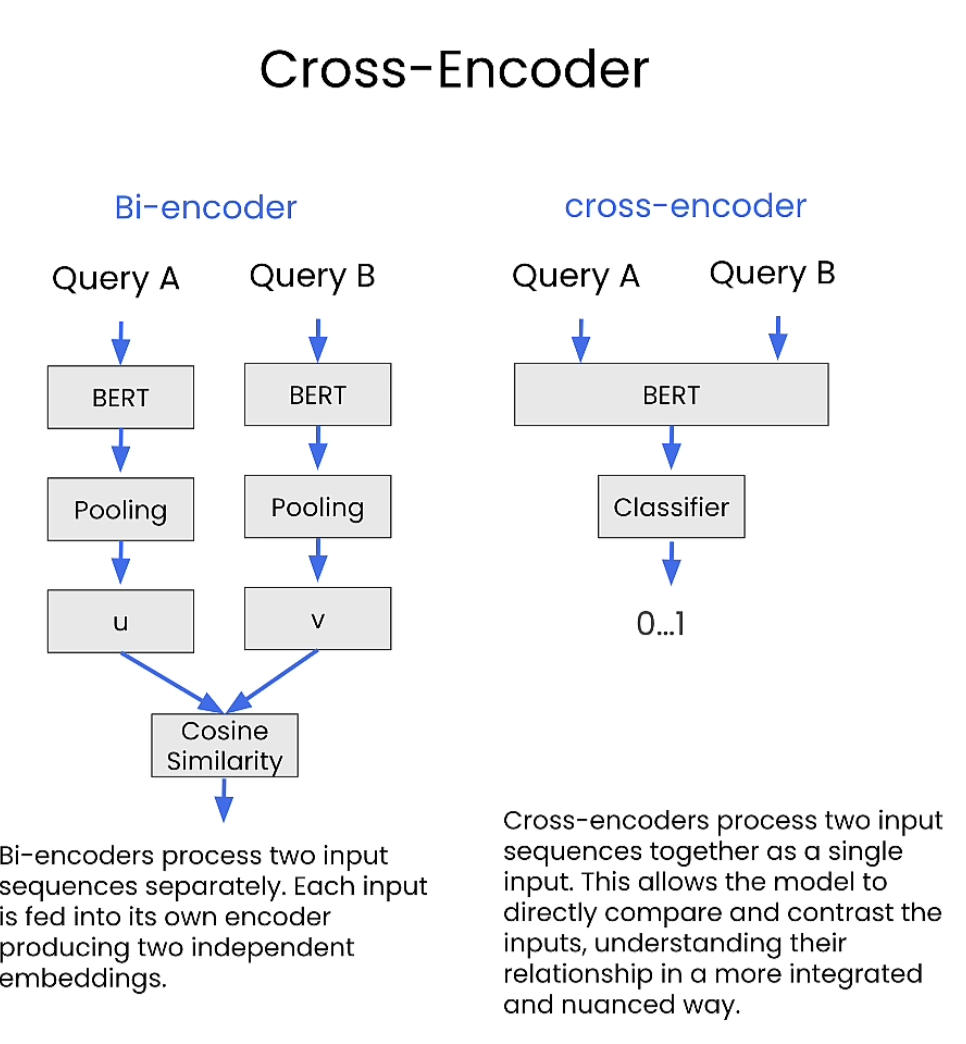

In [ ]:
def compress_context(documents, query, max_length=500):
    """Compress documents to fit context window while preserving relevance"""
    compressed_docs = []
    for doc in documents:
        compression_prompt = f"""
        Compress this document to under {max_length} characters while keeping ALL information relevant to: "{query}"

        Document: {doc}

        Compressed version:
        """

        compressed = llm_gemini(compression_prompt)
        compressed_docs.append(compressed.strip())

    return compressed_docs

In [ ]:
def rerank_with_cross_encoder(query, initial_k=20, final_k=5):
    results = chroma_collection.query(
        query_texts=[query],
        n_results=initial_k,
        include=['documents', 'metadatas']
    )

    pairs = [[query, doc] for doc in results['documents'][0]]
    scores = cross_encoder.predict(pairs)

    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:final_k]

    reranked_docs = [results['documents'][0][i] for i in sorted_indices]
    reranked_metadata = [results['metadatas'][0][i] for i in sorted_indices]

    return reranked_docs, reranked_metadata, [scores[i] for i in sorted_indices]


query = f"Who are the key executives of Franklin Templeton?"
top_docs = rerank_with_cross_encoder(query)
top_docs

(['Management Banking from 2006 to 2007.\nAlok Sethi\nAge 62\nExecutive Vice President and Head of Global Operations of Franklin since February 2023; formerly, Executive Vice \nPresident, Technology and Operations, of Franklin from October 2021 to February 2023; officer and/or director of various \ninvestment adviser, operations, and technology related subsidiaries of Franklin for more than the past five years, including \nas Senior Vice President of Franklin Advisers, Inc., Franklin Templeton Institutional, LLC and Templeton Investment \nCounsel, LLC since July 2014, and Vice President of Franklin Templeton Companies, LLC since June 2010.\nGwen L. Shaneyfelt\nAge 61\nChief Accounting Officer of Franklin since April 2019; officer and/or director of certain subsidiaries of Franklin, including \nas Vice President and Chief Financial Officer of Legg Mason, Inc., Director of ClearBridge Investments, LLC and',
  'contribution where combined we will have \nover $100 billion in AUM. Furthermo

In [ ]:
def rerank_and_compress(query, initial_k=20, final_k=5):
    """Combined reranking and compression"""

    # Step 1: Rerank
    reranked_docs, metadata, scores = rerank_with_cross_encoder(query, initial_k, final_k)

    # Step 2: Compress
    compressed_docs = compress_context(reranked_docs, query)

    print(f"Reranked from {initial_k} to {final_k} docs, then compressed")
    for i, (doc, score) in enumerate(zip(compressed_docs, scores)):
        print(f"Doc {i+1} (score: {score:.3f}): {doc[:100]}...")

    return compressed_docs, metadata, scores


rerank_and_compress("Key executives of Franklin Templeton")

In [ ]:
def intelligent_retrieval_with_citations(query):
    """Enhanced retrieval with reranking, compression, and citations"""

    enhanced_queries = enhance_query(query)
    strategy = route_query(query)

    if strategy == "direct_answer":
        return {"answer": llm_gemini(query), "method": strategy}

    # Step 1: Initial retrieval with more candidates for reranking
    results = chroma_collection.query(
        query_texts=enhanced_queries,
        n_results=15,  # Get more for reranking
        include=['documents', 'metadatas']
    )

    # Step 2: Rerank with cross-encoder
    pairs = [[query, doc] for doc in results['documents'][0]]
    scores = cross_encoder.predict(pairs)
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

    reranked_docs = [results['documents'][0][i] for i in sorted_indices]
    reranked_metadata = [results['metadatas'][0][i] for i in sorted_indices]

    # Step 3: LLM-based compression
    compressed_docs = compress_context(reranked_docs, query, max_length=400)

    # Step 4: Generate answer with citations
    cited_answer = generate_answer_with_citations(query, compressed_docs, reranked_metadata)

    # Add references
    references = "\n\nReferences:\n"
    for i, meta in enumerate(reranked_metadata):
        references += f"[{i+1}] Franklin 10K, Page {meta['page']}\n"

    return {
        "answer": cited_answer + references,
        "method": f"{strategy}_with_reranking",
        "compression_used": True
    }


In [ ]:
def intelligent_rag_with_metrics(query):
    result = intelligent_retrieval_with_citations("Key executives of Franklin Templeton")
    answer = result['answer']
    method = result['method']

    citations = len(re.findall(r'\[(\d+)\]', answer))

    # Count references at bottom
    references = len(re.findall(r'\[\d+\] Franklin', answer))

    print(f"Method: {method}")
    print(f"Answer length: {len(answer)} chars")
    print(f"Citations used: {citations}")
    print(f"Sources: {references} documents")
    print(f"Compression: {result.get('compression_used', False)}")
    print(word_wrap(f"Answer: {answer}..."))

intelligent_rag_with_metrics("Discuss about the key decision makers at Franklin Templeton")